# Exploring the emotions dataset

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


For this project, I am going to combine the dataset from GoEmotions and the twitter Emotion dataset for training the Emotion Detection Model.
GoEmotions consists of 27 classes of emotion and a neutral class, while the twitter dataset consists of 6 emotions and a neutral class. 
The emotions in the GoEmotions dataset will be mapped to the ekman's 6 emotions for better accuracy of the training model and consistency.

# GoEmotions Dataset

### Importing the GoEmotions Dataset

In [88]:
ge_training_data = pd.read_csv("GoEmotions/data/train.tsv", sep='\t', names=['String', 'Emotion', 'Id'])
ge_validation_data = pd.read_csv("GoEmotions/data/dev.tsv", sep='\t', names=['String', 'Emotion', 'Id'])
ge_testing_data = pd.read_csv("GoEmotions/data/test.tsv", sep='\t', names=['String', 'Emotion', 'Id'])

## Sample of the GoEmotions dataset

In [89]:
ge_training_data.loc[0:5]

,String,Emotion,Id
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,26,edvnz26


Average length of the text in the dataset

In [90]:
i = 0
for text in ge_training_data['String']:
    i += len(text.split())
i/len(ge_training_data)

12.840175074867542

In [91]:
ge_training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   String   43410 non-null  object
 1   Emotion  43410 non-null  object
 2   Id       43410 non-null  object
dtypes: object(3)
memory usage: 1017.5+ KB


There are no null rows in the dataset

### some of the class labels in the GoEmotions Dataset consists of multiple class labels for single string. We are going to map them to the ekman's emotions

In [92]:
ge_training_data['Emotion_list'] = ge_training_data['Emotion'].apply(lambda x: x.split(','))
ge_training_data['Emotion_len'] = ge_training_data['Emotion_list'].apply(lambda x: len(x))

ge_testing_data['Emotion_list'] = ge_training_data['Emotion'].apply(lambda x: x.split(','))
ge_testing_data['Emotion_len'] = ge_training_data['Emotion_list'].apply(lambda x: len(x))

ge_validation_data['Emotion_list'] = ge_validation_data['Emotion'].apply(lambda x: x.split(','))
ge_validation_data['Emotion_len'] = ge_validation_data['Emotion_list'].apply(lambda x: len(x))

In [93]:
ge_training_data['Emotion_len'].value_counts()

1    36308
2     6541
3      532
4       28
5        1
Name: Emotion_len, dtype: int64

In [94]:
ge_training_data.query('Emotion_len == 5')

,String,Emotion,Id,Emotion_list,Emotion_len
7873,Yeah I probably would've started crying on the...,"9,12,14,19,25",ee6lqiq,"[9, 12, 14, 19, 25]",5


### We map the GoEmotions to the ekman's emotions based on the mapping provided by the google research

In [95]:
ekman_mapping = {
    "anger": ["anger", "annoyance", "disapproval"],
    "disgust": ["disgust"],
    "fear": ["fear", "nervousness"],
    "joy": ["joy", "amusement", "approval", "excitement", "gratitude", "optimism", "relief", "pride", "admiration", "desire"],
    "sadness": ["sadness", "disappointment", "embarrassment", "grief",  "remorse"],
    "surprise": ["surprise", "realization", "confusion", "curiosity"],
    "love": ["love", "caring"]
}

### Convert the classes into GoEmotion text labels

In [96]:
with open('GoEmotions/data/emotions.txt', 'r') as f:
    lines = f.readlines()
    goemo_dict = {number:emotion.replace('\n','') for number,emotion in enumerate(lines)}

In [97]:
goemo_dict

{0: 'admiration',
 1: 'amusement',
 2: 'anger',
 3: 'annoyance',
 4: 'approval',
 5: 'caring',
 6: 'confusion',
 7: 'curiosity',
 8: 'desire',
 9: 'disappointment',
 10: 'disapproval',
 11: 'disgust',
 12: 'embarrassment',
 13: 'excitement',
 14: 'fear',
 15: 'gratitude',
 16: 'grief',
 17: 'joy',
 18: 'love',
 19: 'nervousness',
 20: 'optimism',
 21: 'pride',
 22: 'realization',
 23: 'relief',
 24: 'remorse',
 25: 'sadness',
 26: 'surprise',
 27: 'neutral'}

In [98]:
def goemotion_label(emotion_list):
    emo_list = []
    for i in emotion_list:
        emo_list.append(goemo_dict[int(i)])
    return emo_list

In [99]:
ge_training_data['GoEmo_label'] = ge_training_data['Emotion_list'].apply(goemotion_label)
ge_testing_data['GoEmo_label'] = ge_testing_data['Emotion_list'].apply(goemotion_label)
ge_validation_data['GoEmo_label'] = ge_validation_data['Emotion_list'].apply(goemotion_label)

In [100]:
ge_training_data.head(5)

,String,Emotion,Id,Emotion_list,Emotion_len,GoEmo_label
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral]
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger]
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear]
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance]


#### Function to convert the GoEmotion Label to Ekman label

In [101]:
def goemo2ekman(goemo_label):
# create a label set so the if there are multiple same emotion then it is stored as one emotion
    label_set = set()
    for goemo in goemo_label:
        if goemo == 'neutral':
            return [goemo]
        for ekman in ekman_mapping:
            if goemo in ekman_mapping[ekman]:
                label_set.add(ekman)
    return list(label_set)


In [102]:
ge_training_data['Ekman_emotion']= ge_training_data['GoEmo_label'].apply(goemo2ekman)
ge_testing_data['Ekman_emotion']= ge_testing_data['GoEmo_label'].apply(goemo2ekman)
ge_validation_data['Ekman_emotion']= ge_validation_data['GoEmo_label'].apply(goemo2ekman)

In [103]:
ge_training_data.head(5)

,String,Emotion,Id,Emotion_list,Emotion_len,GoEmo_label,Ekman_emotion
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral],[neutral]
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral],[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger],[anger]
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear],[fear]
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance],[anger]


## Visualizing the class distribution in the dataset

<Axes: xlabel='emotion', ylabel='Count'>

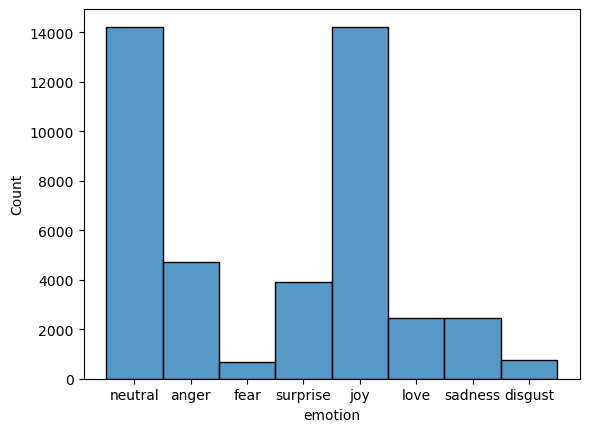

In [104]:
vis_data = pd.DataFrame(ge_training_data['Ekman_emotion'])
vis_data['emotion'] = vis_data['Ekman_emotion'].apply(lambda x: x[0])
sns.histplot(vis_data['emotion'])


The plot shows that the classes neutral and joy are disproportionately represented than other classes.

# Twitter Emotions Dataset from crowdflower

In [105]:
cf_df = pd.read_csv('crowdflower dataset/text_emotion.csv')

In [106]:
cf_df.head(5)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [107]:
cf_df.rename(columns={'content':'String'},inplace=True)

In [108]:
cf_df.shape

(40000, 4)

The dataset consists of 40000 tweets with 13 labelled emotions 

<Axes: xlabel='Count', ylabel='sentiment'>

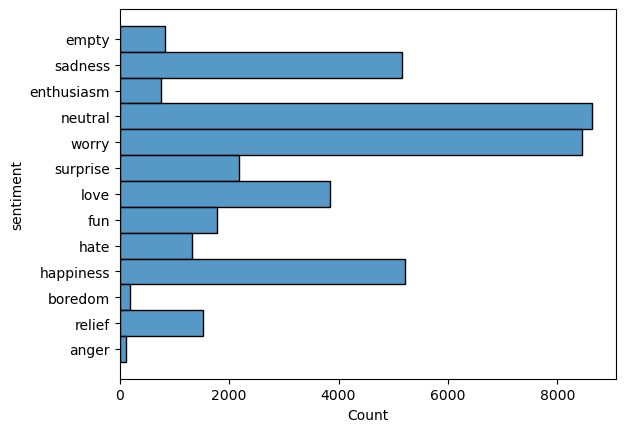

In [109]:
sns.histplot(y=cf_df['sentiment'])

we map the emotions to ekmans emotions

In [110]:
ekman_mapping_for_cf = {
    "anger": ["anger", "hate"],
    "joy": ["happiness", "fun", "relief", "enthusiasm"],
    "sadness": ["sadness", "worry", "empty", "boredom"],
    "surprise": ["surprise"],
    "love": ["love"]
}

In [111]:
cf_df.drop(columns=['tweet_id','author'],inplace=True)

Average text length in the dataset

In [112]:
i = 0
for text in cf_df['String']:
    i += len(text.split())
i/len(cf_df)

13.216875

#### Function to map to Ekman's emotion

In [113]:
def cfemo2ekman(cf_emo):
    if cf_emo == 'neutral':
        return 'neutral'
    for ekman_emo in ekman_mapping_for_cf:
        if cf_emo in ekman_mapping_for_cf[ekman_emo]:
            return ekman_emo

In [114]:
cf_df['Ekman_emotion'] = cf_df['sentiment'].apply(cfemo2ekman)

In [115]:
cf_df.head(5)

,sentiment,String,Ekman_emotion
0,empty,@tiffanylue i know i was listenin to bad habi...,sadness
1,sadness,Layin n bed with a headache ughhhh...waitin o...,sadness
2,sadness,Funeral ceremony...gloomy friday...,sadness
3,enthusiasm,wants to hang out with friends SOON!,joy
4,neutral,@dannycastillo We want to trade with someone w...,neutral


<Axes: xlabel='Ekman_emotion', ylabel='Count'>

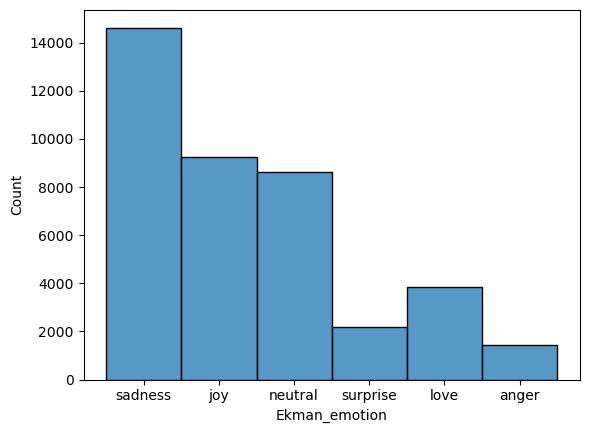

In [116]:
sns.histplot(cf_df['Ekman_emotion'])

We have more sadness class to compensate for the lack of it in the GoEmotions dataset

### Splitting the data into train test and validation sets

We use the scikit learn's train test split function and turn stratify to True to address the class imbalance

In [117]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(cf_df['String'], cf_df['Ekman_emotion'], stratify=cf_df['Ekman_emotion'], test_size=0.1)
X_train_temp = pd.DataFrame(X_train_temp)
y_train_temp = pd.DataFrame(y_train_temp)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.13)
cf_training_data = pd.concat([X_train,y_train], axis = 1)
cf_testing_data = pd.concat([X_test,y_test], axis=1)
cf_validation_data = pd.concat([X_val, y_val], axis=1)

In [118]:
cf_training_data.head()

,String,Ekman_emotion
34891,watching saturday night live; justin timberlak...,neutral
83,goooood mooorning people... sun is out.. defin...,sadness
8904,Flash lost my frisby on a roof. Sad days LOL,sadness
35633,its like 2 in the morning..sometimes I just do...,sadness
20199,can't sleep so i'm watching some more Gilmore ...,neutral


#### We Concatenate both the GoEmotion dataset and the Crowdflower dataset

In [119]:
train_data = pd.concat([cf_training_data,ge_training_data[['String','Ekman_emotion']]], axis=0)
test_data = pd.concat([cf_testing_data,ge_testing_data[['String','Ekman_emotion']]], axis=0)
validation_data = pd.concat([cf_validation_data,ge_validation_data[['String','Ekman_emotion']]], axis=0)

In [120]:
train_data['Primary_emotion'] = train_data['Ekman_emotion'].apply(lambda x: x if type(x) == str else x[0])

<Axes: xlabel='Primary_emotion', ylabel='Count'>

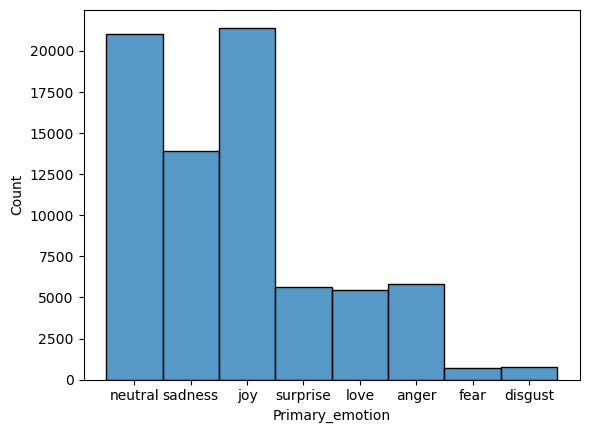

In [121]:
sns.histplot(train_data['Primary_emotion'])

## This dataset is highly imbalanced. We are going to undersample the highly represented classes

In [122]:
joy = train_data[train_data['Primary_emotion'] == 'joy']
neutral = train_data[train_data['Primary_emotion'] == 'neutral']
sadness = train_data[train_data['Primary_emotion'] == 'sadness']
anger = train_data[train_data['Primary_emotion'] == 'anger']
love = train_data[train_data['Primary_emotion'] == 'love']
surprise = train_data[train_data['Primary_emotion'] == 'surprise']
fear = train_data[train_data['Primary_emotion'] == 'fear']
disgust = train_data[train_data['Primary_emotion'] == 'disgust']

In [123]:
joy_resampled = joy.sample(n=5000, random_state=0)
neutral_resampled = neutral.sample(n=5000, random_state=0)
sadness_resampled = sadness.sample(n=5000, random_state=0)
anger_resampled = anger.sample(n=5000, random_state=0)

In [124]:
train_data_resampled = pd.concat([joy_resampled,neutral_resampled,sadness_resampled,anger,love,surprise,fear,disgust], axis = 0)

In [125]:
train_data_resampled['Primary_emotion'].value_counts()

anger       5836
surprise    5659
love        5452
joy         5000
neutral     5000
sadness     5000
disgust      763
fear         686
Name: Primary_emotion, dtype: int64

The fear and disgust class is highly imbalanced. We can import another dataset and extract only the fear emotion class from the dataset to compensate for that.

## Importing emotion dataset from DAIR AI to import the fear class

In [126]:
dar_test = pd.read_json('dair-ai emotion dataset/test.jsonl', lines=True)
dar_train = pd.read_json('dair-ai emotion dataset/train.jsonl', lines = True)
dar_val = pd.read_json('dair-ai emotion dataset/validation.jsonl', lines=True)

In [127]:
dar_train.rename(columns={'text':'String'}, inplace=True)
dar_test.rename(columns={'text':'String'}, inplace=True)
dar_val.rename(columns={'text':'String'}, inplace=True)

In [128]:
dar_data = pd.concat([dar_train,dar_test,dar_val], axis=0)

In [129]:
dar_data.head()

,String,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


/var/folders/t0/prcwsryx44jd6j6zsp98vwch0000gn/T/ipykernel_57661/1802361852.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','sadness','joy','love', 'anger','fear', 'surprise'])


Text(0.5, 0, 'emotion')

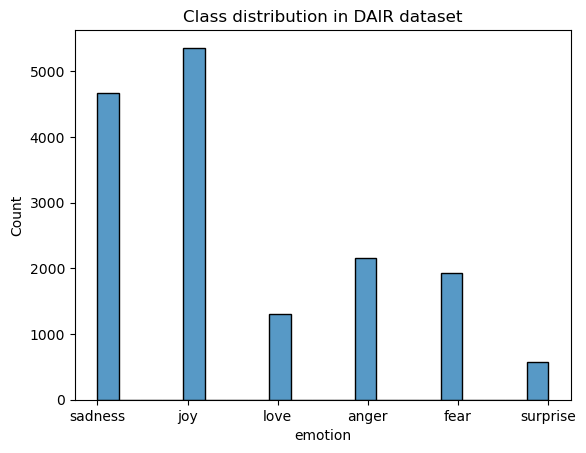

In [130]:
ax = plt.subplot()
sns.histplot(dar_train['label'])
ax.set_xticklabels(['','sadness','joy','love', 'anger','fear', 'surprise'])
ax.set_title('Class distribution in DAIR dataset')
ax.set_xlabel('emotion')

### Extracting only the fear class from the dataset

In [131]:
dar_fear = dar_data[dar_data['label'] == 4]

In [132]:
dar_fear.shape

(2373, 2)

In [133]:
dar_fear['Primary_emotion'] = 'fear'
dar_fear['Ekman_emotion'] = 'fear'

/var/folders/t0/prcwsryx44jd6j6zsp98vwch0000gn/T/ipykernel_57661/3566196402.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dar_fear['Primary_emotion'] = 'fear'
/var/folders/t0/prcwsryx44jd6j6zsp98vwch0000gn/T/ipykernel_57661/3566196402.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dar_fear['Ekman_emotion'] = 'fear'


In [134]:
dar_fear.head()

,String,label,Primary_emotion,Ekman_emotion
7,i feel as confused about life as a teenager or...,4,fear,fear
19,i now feel compromised and skeptical of the va...,4,fear,fear
21,i am feeling completely overwhelmed i have two...,4,fear,fear
31,i remember feeling acutely distressed for a fe...,4,fear,fear
53,i was stymied a little bit as i wrote feeling ...,4,fear,fear


In [135]:
train_data_final = pd.concat([train_data_resampled, dar_fear],axis=0)

In [136]:
train_data_final['Primary_emotion'].value_counts()

anger       5836
surprise    5659
love        5452
joy         5000
neutral     5000
sadness     5000
fear        3059
disgust      763
Name: Primary_emotion, dtype: int64

In [137]:
train_data_final.drop(columns=['label'],inplace=True)

<Axes: xlabel='Primary_emotion', ylabel='Count'>

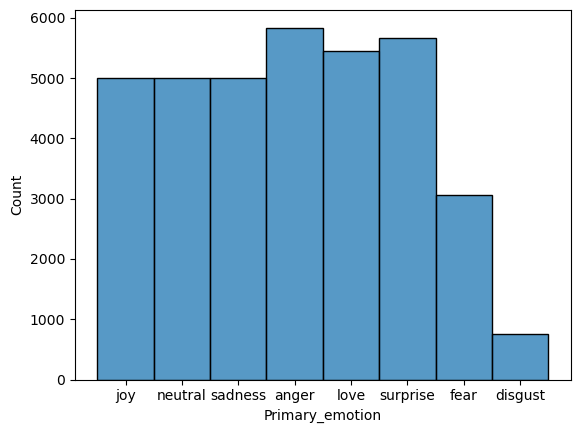

In [138]:
sns.histplot(train_data_final['Primary_emotion'])

The emotions are better represented but the disgust emotion is highly underrepresented, hence, it can be dropped

If emotion is enclosed inside list extract it from the list

In [139]:
test_data['Primary_emotion'] = test_data['Ekman_emotion'].apply(lambda x: x if type(x) == str else x[0])
validation_data['Primary_emotion'] = validation_data['Ekman_emotion'].apply(lambda x: x if type(x) == str else x[0])

# Export the final train, test and validation dataset

Export the complete dataset including train, test and validation sets

In [140]:
full_df = pd.concat([train_data_final,test_data,validation_data], axis=0)
full_df.drop(index=full_df[full_df['Primary_emotion']=="disgust"].index,inplace=True)

<Axes: xlabel='Primary_emotion', ylabel='Count'>

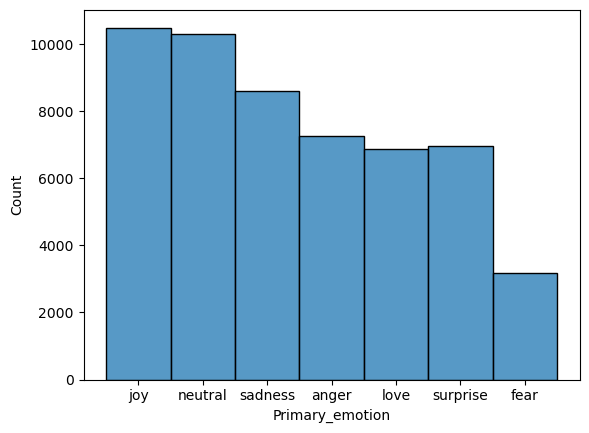

In [141]:
sns.histplot(full_df['Primary_emotion'])

Map the emotions to codes

In [142]:
emotion_map = {
    'neutral':0,
    'joy':1,
    'sadness':2,
    'anger':3,
    'love':4,
    'surprise':5,
    'fear':6
}

In [143]:
full_df['Emotion_code'] = full_df['Primary_emotion'].map(emotion_map)

In [144]:
full_df = full_df.sample(frac=0.1, random_state=42)

In [145]:
full_df.rename(columns={'label':'Primary_emotion'}, inplace=True)

In [146]:
full_df.head()

,String,Ekman_emotion,Primary_emotion,Emotion_code
402,ya how dare anyone like live and breathe aroun...,[anger],anger,3
14151,"Not in Tuscaloosa, it's been a looooong time s...",[neutral],neutral,0
27526,"He missed my personal favorite of ""harridan"" t...",[neutral],neutral,0
1655,Also op I have my associates on top of my bach...,[joy],joy,1
1038,@Jessicaveronica OMG YAYA!!! we put you #5 ple...,sadness,sadness,2


In [147]:
full_df.to_csv('final dataset/full_emotion_dataset.csv', index=False)